In [30]:
import torch
from IPython.display import Audio
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from PIL import Image
from scripts.train_unet import clMusDiff

Initialize random values generator

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device)

Load pipeline

In [63]:
pipe = clMusDiff.from_pretrained("models/clMusDiffv2_1")
pipe.to(device);

Loading pipeline components...: 100%|██████████| 4/4 [00:00<00:00, 48.77it/s]


Initialize image feature encoder

In [64]:
from diffusers import ModelMixin, ConfigMixin

class ImageEncoder(ModelMixin, ConfigMixin):
    def __init__(self, image_processor, encoder_model):
        super().__init__()
        self.processor = image_processor
        self.encoder = encoder_model
        self.eval()
        
    def forward(self, x):
        x = self.encoder(x)
        return x
        
    @torch.no_grad()
    def encode(self, image_files):
        images = [Image.open(image_file) for image_file in image_files]
        x = self.processor(images, return_tensors="pt")['pixel_values']
        y = self(x)
        y = y.last_hidden_state
        embedings = y[:,0,:] 
        return embedings

In [65]:
processor = CLIPImageProcessor.from_pretrained('openai/clip-vit-large-patch14')
extractor = CLIPVisionModelWithProjection.from_pretrained('openai/clip-vit-large-patch14')

image_encoder = ImageEncoder(processor, extractor)

Encode sample image

In [66]:
encoding = torch.unsqueeze(image_encoder.encode(['sample2.png']), axis=1).to(device)

In [67]:
out = pipe(
    batch_size=1,
    generator=generator, 
    encoding=encoding,
)

100%|██████████| 50/50 [00:01<00:00, 38.18it/s]


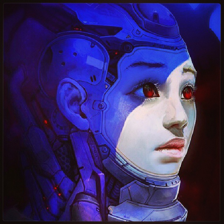

In [68]:
Image.open("sample2.png").resize((224,224))

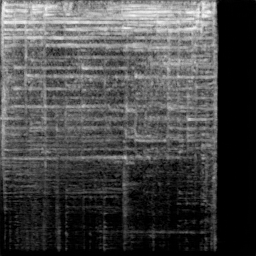

In [69]:
out[0][0]

In [70]:
display(Audio(out[1][0], rate=pipe.mel.get_sample_rate()))